<a href="https://colab.research.google.com/github/TamBui1706/MLOps/blob/main/Week02/Ex02/Notebook02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 02 - BÀI 2: Tăng cường dữ liệu ảnh CIFAR-10

## Mục tiêu:
1. Chọn 5 lớp từ CIFAR-10, mỗi lớp 1000 ảnh (5000 ảnh)
2. Áp dụng các kỹ thuật Data Augmentation
3. Huấn luyện mô hình với 2 trường hợp: có/không augmentation
4. Chạy 3 lần mỗi cấu hình và lấy trung bình
5. So sánh hiệu năng và tốc độ hội tụ
6. Sử dụng WandB để theo dõi
7. Tạo giao diện Gradio

## 1. Cài đặt thư viện

In [ ]:
!pip install -q torch torchvision wandb matplotlib seaborn pandas numpy pillow gradio scikit-learn plotly tensorboard

## 2. Import thư viện

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import gradio as gr

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import wandb
import time
import copy
from collections import defaultdict

print("Thư viện đã được import thành công!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Thư viện đã được import thành công!
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4


## 3. Thiết lập thông số

In [ ]:
# Cấu hình
SELECTED_CLASSES = [0, 1, 2, 3, 4]  # airplane, automobile, bird, cat, deer
SAMPLES_PER_CLASS = 1000
TOTAL_SAMPLES = 5000
BATCH_SIZE = 64
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
NUM_RUNS = 3  # Chạy 3 lần
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tên các lớp CIFAR-10
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
SELECTED_CLASS_NAMES = [CIFAR10_CLASSES[i] for i in SELECTED_CLASSES]

print(f"Device: {DEVICE}")
print(f"Selected classes: {SELECTED_CLASS_NAMES}")
print(f"Total training samples: {TOTAL_SAMPLES}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Number of runs per config: {NUM_RUNS}")

Device: cuda
Selected classes: ['airplane', 'automobile', 'bird', 'cat', 'deer']
Total training samples: 5000
Batch size: 64
Number of epochs: 50
Number of runs per config: 3


## 4. Khởi tạo WandB

In [ ]:
wandb.login()

# Khởi tạo run chính
wandb.init(
    project="cifar10-augmentation",
    name="augmentation-comparison",
    config={
        "dataset": "CIFAR-10",
        "selected_classes": SELECTED_CLASS_NAMES,
        "samples_per_class": SAMPLES_PER_CLASS,
        "batch_size": BATCH_SIZE,
        "epochs": NUM_EPOCHS,
        "learning_rate": LEARNING_RATE,
        "num_runs": NUM_RUNS,
        "device": str(DEVICE)
    }
)

print("WandB đã được khởi tạo!")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: builehongtamk16 (builehongtamk16-hi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference, mcp] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


WandB đã được khởi tạo!


## 5. Tải và chuẩn bị dữ liệu

In [ ]:
# Transform cơ bản (không augmentation)
transform_basic = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Transform với augmentation
transform_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

print("Transforms đã được định nghĩa")
print("\nTransform cơ bản:")
print(transform_basic)
print("\nTransform augmented:")
print(transform_augmented)

Transforms đã được định nghĩa

Transform cơ bản:
Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)

Transform augmented:
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
    RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)


In [ ]:
# Tải CIFAR-10
print("Đang tải CIFAR-10 dataset...")
trainset_full = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=None
)
testset_full = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=None
)

print(f"Tổng số mẫu train: {len(trainset_full)}")
print(f"Tổng số mẫu test: {len(testset_full)}")

Đang tải CIFAR-10 dataset...


100%|██████████| 170M/170M [00:03<00:00, 45.3MB/s]


Tổng số mẫu train: 50000
Tổng số mẫu test: 10000


In [ ]:
# Chọn 5000 mẫu (5 lớp, mỗi lớp 1000 mẫu)
def select_samples(dataset, selected_classes, samples_per_class):
    indices = []
    class_counts = {c: 0 for c in selected_classes}

    for idx, (_, label) in enumerate(dataset):
        if label in selected_classes and class_counts[label] < samples_per_class:
            indices.append(idx)
            class_counts[label] += 1

        if all(count >= samples_per_class for count in class_counts.values()):
            break

    return indices

print("Đang chọn mẫu từ các lớp...")
train_indices = select_samples(trainset_full, SELECTED_CLASSES, SAMPLES_PER_CLASS)
print(f"Đã chọn {len(train_indices)} mẫu từ tập train")

# Chọn test samples cho các lớp đã chọn
test_indices = [i for i, (_, label) in enumerate(testset_full) if label in SELECTED_CLASSES]
print(f"Có {len(test_indices)} mẫu test cho các lớp đã chọn")

Đang chọn mẫu từ các lớp...
Đã chọn 5000 mẫu từ tập train
Có 5000 mẫu test cho các lớp đã chọn


In [ ]:
# Hiển thị phân phối các lớp
train_labels = [trainset_full[i][1] for i in train_indices]
train_class_counts = pd.Series(train_labels).value_counts().sort_index()

fig = go.Figure(data=[
    go.Bar(
        x=[CIFAR10_CLASSES[i] for i in train_class_counts.index],
        y=train_class_counts.values,
        text=train_class_counts.values,
        textposition='auto',
    )
])
fig.update_layout(
    title='Phân phối các lớp trong tập train',
    xaxis_title='Lớp',
    yaxis_title='Số lượng'
)
fig.show()

wandb.log({"class_distribution": fig})

## 6. Hiển thị ảnh gốc và ảnh augmented

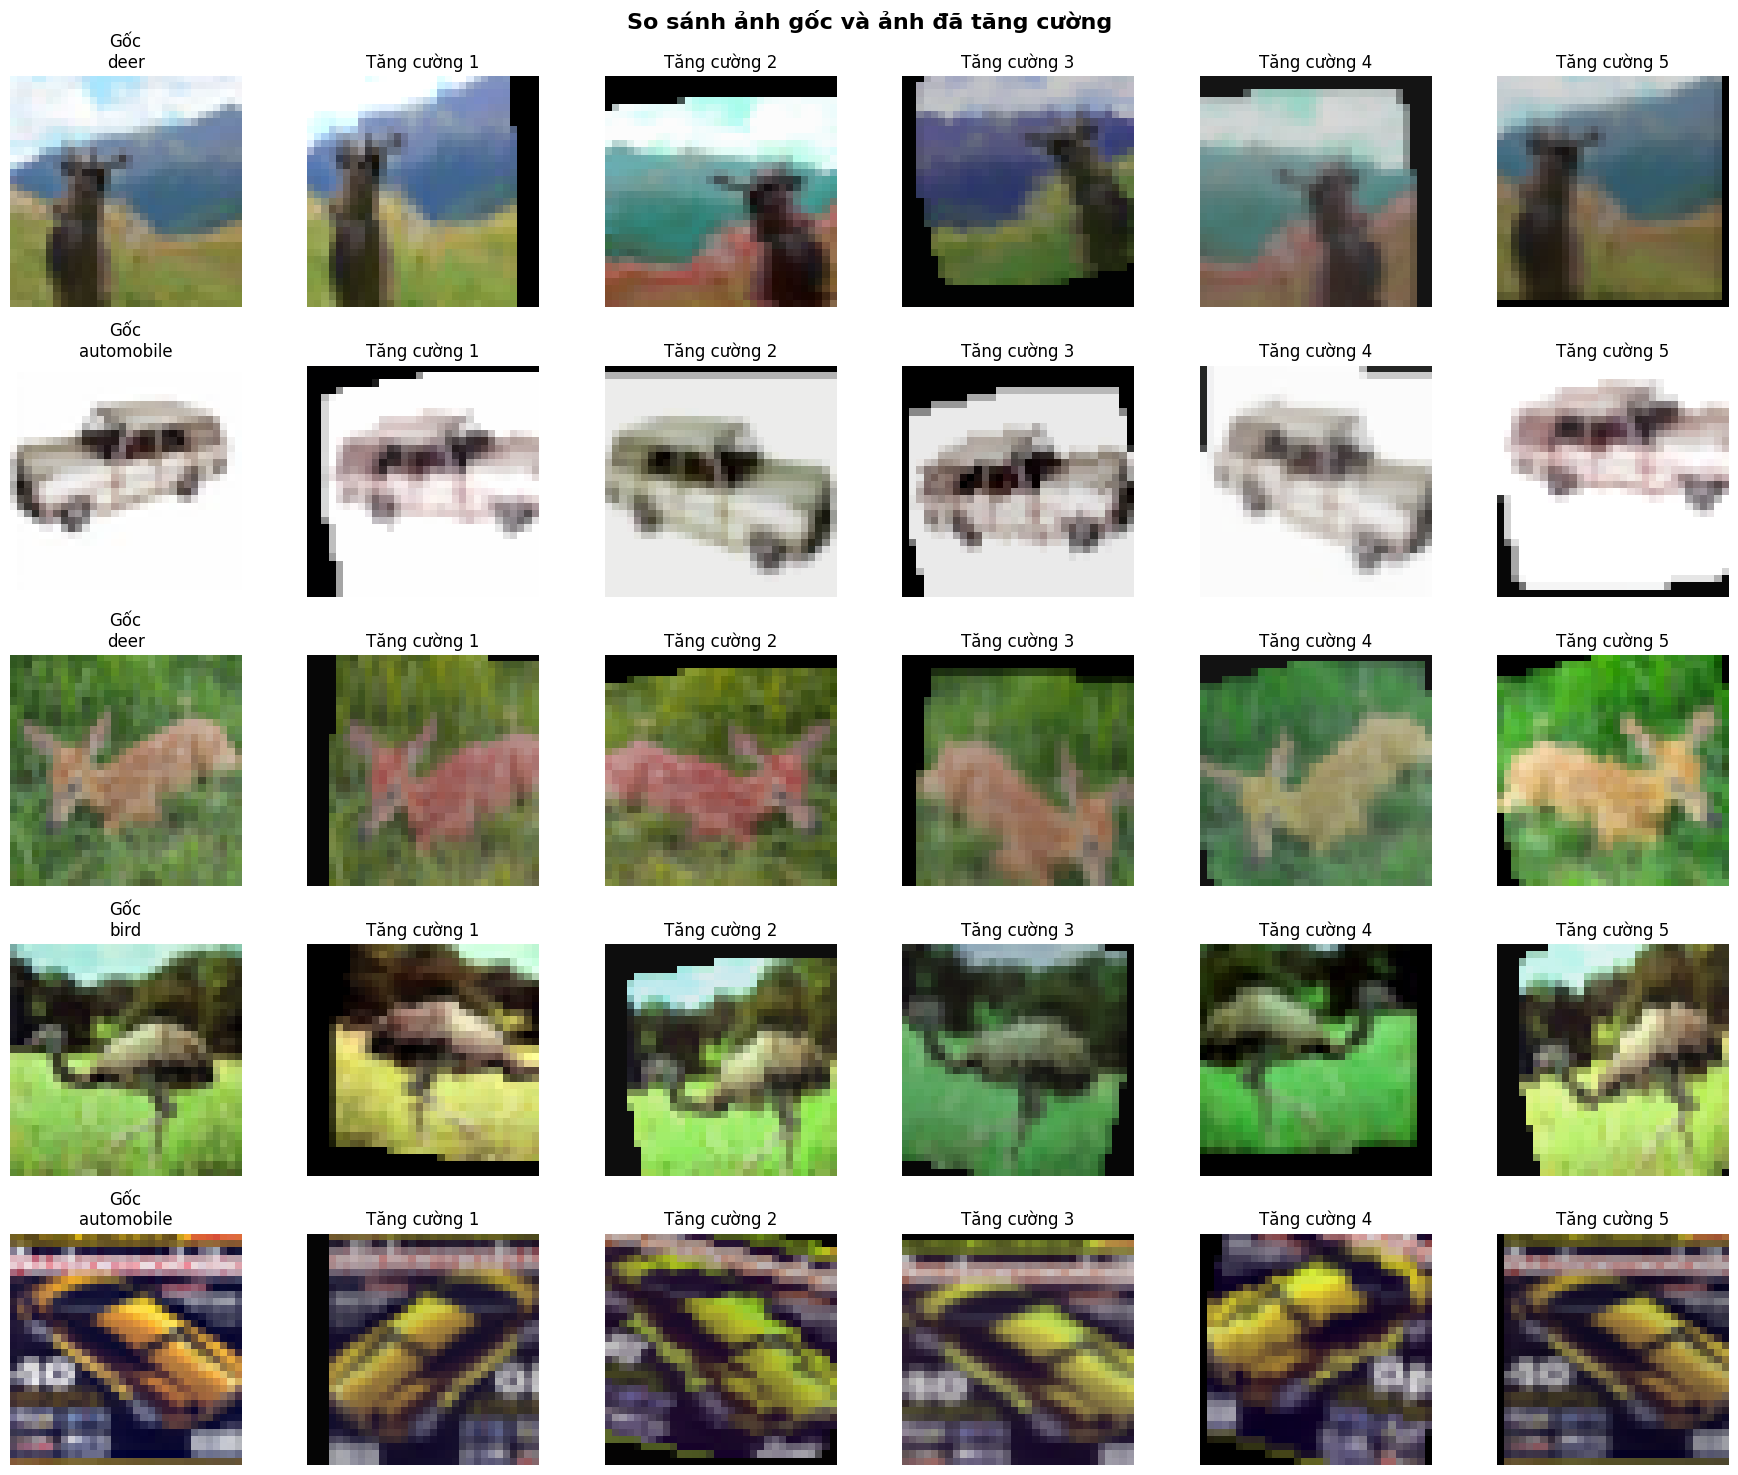

Đã lưu ảnh minh họa augmentation


In [ ]:
# Lấy một số mẫu ngẫu nhiên
np.random.seed(42)
sample_indices = np.random.choice(train_indices, 5, replace=False)

fig, axes = plt.subplots(5, 6, figsize=(18, 15))
fig.suptitle('So sánh ảnh gốc và ảnh đã tăng cường', fontsize=16, fontweight='bold')

for i, idx in enumerate(sample_indices):
    img, label = trainset_full[idx]

    # Ảnh gốc
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Gốc\n{CIFAR10_CLASSES[label]}')
    axes[i, 0].axis('off')

    # 5 ảnh augmented
    for j in range(5):
        aug_img = transform_augmented(img)
        # Denormalize để hiển thị
        aug_img = aug_img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
        aug_img = aug_img + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
        aug_img = torch.clamp(aug_img, 0, 1)
        aug_img = aug_img.permute(1, 2, 0).numpy()

        axes[i, j+1].imshow(aug_img)
        axes[i, j+1].set_title(f'Tăng cường {j+1}')
        axes[i, j+1].axis('off')

plt.tight_layout()
plt.savefig('augmentation_examples.png', dpi=150, bbox_inches='tight')
plt.show()

wandb.log({"augmentation_examples": wandb.Image('augmentation_examples.png')})
print("Đã lưu ảnh minh họa augmentation")

## 7. Tạo Custom Dataset

In [ ]:
class CIFAR10Subset(Dataset):
    def __init__(self, dataset, indices, transform=None, class_mapping=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
        self.class_mapping = class_mapping if class_mapping else {c: i for i, c in enumerate(SELECTED_CLASSES)}

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]

        if self.transform:
            img = self.transform(img)

        # Map label về [0, 1, 2, 3, 4]
        label = self.class_mapping[label]

        return img, label

# Tạo class mapping
class_mapping = {c: i for i, c in enumerate(SELECTED_CLASSES)}
print(f"Class mapping: {class_mapping}")

Class mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


## 8. Định nghĩa mô hình CNN

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Test model
model = SimpleCNN(num_classes=5).to(DEVICE)
print("Mô hình CNN:")
print(model)

# Đếm số parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTổng số parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Mô hình CNN:
SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0,

## 9. Hàm huấn luyện và đánh giá

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels

print("Hàm train và validate đã được định nghĩa")

Hàm train và validate đã được định nghĩa


In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer,
                scheduler, num_epochs, device, run_name=""):
    """
    Huấn luyện mô hình và trả về lịch sử
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'best_acc': 0.0,
        'best_model': None
    }

    start_time = time.time()

    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        test_loss, test_acc, _, _ = validate(model, test_loader, criterion, device)

        # Scheduler step
        scheduler.step()

        # Lưu lịch sử
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        # Lưu best model
        if test_acc > history['best_acc']:
            history['best_acc'] = test_acc
            history['best_model'] = copy.deepcopy(model.state_dict())

        # Log to WandB
        wandb.log({
            f"{run_name}_train_loss": train_loss,
            f"{run_name}_train_acc": train_acc,
            f"{run_name}_test_loss": test_loss,
            f"{run_name}_test_acc": test_acc,
            f"{run_name}_epoch": epoch + 1
        })

        # In kết quả
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"  Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

    training_time = time.time() - start_time
    history['training_time'] = training_time

    print(f"\nHoàn thành huấn luyện!")
    print(f"Thời gian huấn luyện: {training_time:.2f}s")
    print(f"Best test accuracy: {history['best_acc']:.2f}%")

    return history

print("Hàm train_model đã được định nghĩa")

Hàm train_model đã được định nghĩa


## 10. Chạy thực nghiệm - Không có Augmentation

In [ ]:
print("="*80)
print("TRƯỜNG HỢP 1: KHÔNG CÓ AUGMENTATION")
print("="*80)

results_no_aug = []

for run in range(NUM_RUNS):
    print(f"\n--- Lần chạy {run+1}/{NUM_RUNS} ---")

    # Tạo datasets
    trainset_no_aug = CIFAR10Subset(trainset_full, train_indices,
                                     transform=transform_basic,
                                     class_mapping=class_mapping)
    testset_no_aug = CIFAR10Subset(testset_full, test_indices,
                                    transform=transform_basic,
                                    class_mapping=class_mapping)

    train_loader = DataLoader(trainset_no_aug, batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=2)
    test_loader = DataLoader(testset_no_aug, batch_size=BATCH_SIZE,
                            shuffle=False, num_workers=2)

    # Khởi tạo model
    model = SimpleCNN(num_classes=5).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    # Train
    history = train_model(model, train_loader, test_loader, criterion,
                         optimizer, scheduler, NUM_EPOCHS, DEVICE,
                         run_name=f"no_aug_run{run+1}")

    results_no_aug.append(history)

    print(f"Lần chạy {run+1} hoàn thành - Best Acc: {history['best_acc']:.2f}%")

print("\nHoàn thành tất cả các lần chạy cho trường hợp KHÔNG CÓ AUGMENTATION")

TRƯỜNG HỢP 1: KHÔNG CÓ AUGMENTATION

--- Lần chạy 1/3 ---
Epoch [5/50]
  Train Loss: 0.8174 | Train Acc: 67.02%
  Test Loss: 0.9203 | Test Acc: 65.48%
Epoch [10/50]
  Train Loss: 0.6036 | Train Acc: 76.88%
  Test Loss: 0.6632 | Test Acc: 75.32%
Epoch [15/50]
  Train Loss: 0.4382 | Train Acc: 83.58%
  Test Loss: 0.6486 | Test Acc: 77.44%
Epoch [20/50]
  Train Loss: 0.2985 | Train Acc: 89.14%
  Test Loss: 0.6023 | Test Acc: 80.08%
Epoch [25/50]
  Train Loss: 0.2115 | Train Acc: 92.10%
  Test Loss: 0.6271 | Test Acc: 80.62%
Epoch [30/50]
  Train Loss: 0.1319 | Train Acc: 95.36%
  Test Loss: 0.7170 | Test Acc: 80.78%
Epoch [35/50]
  Train Loss: 0.1163 | Train Acc: 95.68%
  Test Loss: 0.7547 | Test Acc: 81.28%
Epoch [40/50]
  Train Loss: 0.0782 | Train Acc: 97.12%
  Test Loss: 0.7412 | Test Acc: 82.38%
Epoch [45/50]
  Train Loss: 0.0574 | Train Acc: 98.08%
  Test Loss: 0.7701 | Test Acc: 82.14%
Epoch [50/50]
  Train Loss: 0.0593 | Train Acc: 98.08%
  Test Loss: 0.7675 | Test Acc: 82.42%

Ho

## 11. Chạy thực nghiệm - Có Augmentation

In [ ]:
print("="*80)
print("TRƯỜNG HỢP 2: CÓ AUGMENTATION")
print("="*80)

results_with_aug = []

for run in range(NUM_RUNS):
    print(f"\n--- Lần chạy {run+1}/{NUM_RUNS} ---")

    # Tạo datasets
    trainset_aug = CIFAR10Subset(trainset_full, train_indices,
                                 transform=transform_augmented,
                                 class_mapping=class_mapping)
    testset_aug = CIFAR10Subset(testset_full, test_indices,
                                transform=transform_basic,
                                class_mapping=class_mapping)

    train_loader = DataLoader(trainset_aug, batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=2)
    test_loader = DataLoader(testset_aug, batch_size=BATCH_SIZE,
                            shuffle=False, num_workers=2)

    # Khởi tạo model
    model = SimpleCNN(num_classes=5).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    # Train
    history = train_model(model, train_loader, test_loader, criterion,
                         optimizer, scheduler, NUM_EPOCHS, DEVICE,
                         run_name=f"with_aug_run{run+1}")

    results_with_aug.append(history)

    print(f"Lần chạy {run+1} hoàn thành - Best Acc: {history['best_acc']:.2f}%")

print("\nHoàn thành tất cả các lần chạy cho trường hợp CÓ AUGMENTATION")

TRƯỜNG HỢP 2: CÓ AUGMENTATION

--- Lần chạy 1/3 ---
Epoch [5/50]
  Train Loss: 1.0302 | Train Acc: 57.98%
  Test Loss: 0.8977 | Test Acc: 62.88%
Epoch [10/50]
  Train Loss: 0.8936 | Train Acc: 63.74%
  Test Loss: 0.7944 | Test Acc: 69.04%
Epoch [15/50]
  Train Loss: 0.8050 | Train Acc: 68.30%
  Test Loss: 0.6804 | Test Acc: 73.32%
Epoch [20/50]
  Train Loss: 0.7300 | Train Acc: 71.68%
  Test Loss: 0.5849 | Test Acc: 77.52%
Epoch [25/50]
  Train Loss: 0.6568 | Train Acc: 74.20%
  Test Loss: 0.5499 | Test Acc: 79.34%
Epoch [30/50]
  Train Loss: 0.5858 | Train Acc: 77.84%
  Test Loss: 0.5446 | Test Acc: 80.28%
Epoch [35/50]
  Train Loss: 0.5567 | Train Acc: 79.14%
  Test Loss: 0.5268 | Test Acc: 80.52%
Epoch [40/50]
  Train Loss: 0.5083 | Train Acc: 80.82%
  Test Loss: 0.5058 | Test Acc: 81.92%
Epoch [45/50]
  Train Loss: 0.5040 | Train Acc: 81.70%
  Test Loss: 0.4985 | Test Acc: 82.36%
Epoch [50/50]
  Train Loss: 0.4979 | Train Acc: 81.48%
  Test Loss: 0.4959 | Test Acc: 82.08%

Hoàn thà

## 12. Tính toán trung bình và so sánh kết quả

In [ ]:
# Tính trung bình cho không có augmentation
avg_train_loss_no_aug = np.mean([r['train_loss'] for r in results_no_aug], axis=0)
avg_train_acc_no_aug = np.mean([r['train_acc'] for r in results_no_aug], axis=0)
avg_test_loss_no_aug = np.mean([r['test_loss'] for r in results_no_aug], axis=0)
avg_test_acc_no_aug = np.mean([r['test_acc'] for r in results_no_aug], axis=0)
avg_best_acc_no_aug = np.mean([r['best_acc'] for r in results_no_aug])
avg_time_no_aug = np.mean([r['training_time'] for r in results_no_aug])

# Tính trung bình cho có augmentation
avg_train_loss_with_aug = np.mean([r['train_loss'] for r in results_with_aug], axis=0)
avg_train_acc_with_aug = np.mean([r['train_acc'] for r in results_with_aug], axis=0)
avg_test_loss_with_aug = np.mean([r['test_loss'] for r in results_with_aug], axis=0)
avg_test_acc_with_aug = np.mean([r['test_acc'] for r in results_with_aug], axis=0)
avg_best_acc_with_aug = np.mean([r['best_acc'] for r in results_with_aug])
avg_time_with_aug = np.mean([r['training_time'] for r in results_with_aug])

print("="*80)
print("KẾT QUẢ TRUNG BÌNH")
print("="*80)
print(f"\nKHÔNG CÓ AUGMENTATION:")
print(f"  Độ chính xác test trung bình: {avg_best_acc_no_aug:.2f}%")
print(f"  Thời gian huấn luyện trung bình: {avg_time_no_aug:.2f}s")

print(f"\nCÓ AUGMENTATION:")
print(f"  Độ chính xác test trung bình: {avg_best_acc_with_aug:.2f}%")
print(f"  Thời gian huấn luyện trung bình: {avg_time_with_aug:.2f}s")

print(f"\nSO SÁNH:")
improvement = avg_best_acc_with_aug - avg_best_acc_no_aug
print(f"  Cải thiện độ chính xác: {improvement:+.2f}%")
time_diff = avg_time_with_aug - avg_time_no_aug
print(f"  Chênh lệch thời gian: {time_diff:+.2f}s")

KẾT QUẢ TRUNG BÌNH

KHÔNG CÓ AUGMENTATION:
  Độ chính xác test trung bình: 82.23%
  Thời gian huấn luyện trung bình: 148.99s

CÓ AUGMENTATION:
  Độ chính xác test trung bình: 81.97%
  Thời gian huấn luyện trung bình: 327.98s

SO SÁNH:
  Cải thiện độ chính xác: -0.27%
  Chênh lệch thời gian: +178.99s


## 13. Vẽ biểu đồ so sánh

In [ ]:
# Vẽ loss và accuracy curves
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Loss Huấn luyện', 'Độ chính xác Huấn luyện',
                   'Loss Kiểm tra', 'Độ chính xác Kiểm tra')
)

epochs = list(range(1, NUM_EPOCHS + 1))

# Training Loss
fig.add_trace(
    go.Scatter(x=epochs, y=avg_train_loss_no_aug, name='Không Aug',
              mode='lines', line=dict(color='red')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=epochs, y=avg_train_loss_with_aug, name='Có Aug',
              mode='lines', line=dict(color='green')),
    row=1, col=1
)

# Training Accuracy
fig.add_trace(
    go.Scatter(x=epochs, y=avg_train_acc_no_aug, name='Không Aug',
              mode='lines', line=dict(color='red'), showlegend=False),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=epochs, y=avg_train_acc_with_aug, name='Có Aug',
              mode='lines', line=dict(color='green'), showlegend=False),
    row=1, col=2
)

# Test Loss
fig.add_trace(
    go.Scatter(x=epochs, y=avg_test_loss_no_aug, name='Không Aug',
              mode='lines', line=dict(color='red'), showlegend=False),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=epochs, y=avg_test_loss_with_aug, name='Có Aug',
              mode='lines', line=dict(color='green'), showlegend=False),
    row=2, col=1
)

# Test Accuracy
fig.add_trace(
    go.Scatter(x=epochs, y=avg_test_acc_no_aug, name='Không Aug',
              mode='lines', line=dict(color='red'), showlegend=False),
    row=2, col=2
)
fig.add_trace(
    go.Scatter(x=epochs, y=avg_test_acc_with_aug, name='Có Aug',
              mode='lines', line=dict(color='green'), showlegend=False),
    row=2, col=2
)

fig.update_xaxes(title_text="Epoch", row=2, col=1)
fig.update_xaxes(title_text="Epoch", row=2, col=2)
fig.update_yaxes(title_text="Loss", row=1, col=1)
fig.update_yaxes(title_text="Độ chính xác (%)", row=1, col=2)
fig.update_yaxes(title_text="Loss", row=2, col=1)
fig.update_yaxes(title_text="Độ chính xác (%)", row=2, col=2)

fig.update_layout(height=800, showlegend=True,
                 title_text="So sánh lịch sử huấn luyện (Trung bình 3 lần chạy)")
fig.show()

wandb.log({"training_comparison": fig})

In [ ]:
# So sánh accuracy cuối cùng
comparison_data = pd.DataFrame({
    'Cấu hình': ['Không Augmentation', 'Có Augmentation'],
    'Độ chính xác TB tốt nhất': [avg_best_acc_no_aug, avg_best_acc_with_aug],
    'Thời gian huấn luyện (s)': [avg_time_no_aug, avg_time_with_aug]
})

print("\nBảng so sánh chi tiết:")
display(comparison_data)

wandb.log({"comparison_table": wandb.Table(dataframe=comparison_data)})


Bảng so sánh chi tiết:


,Cấu hình,Độ chính xác TB tốt nhất,Thời gian huấn luyện (s)
0,Không Augmentation,82.233333,148.985119
1,Có Augmentation,81.966667,327.976344


In [ ]:
# Vẽ biểu đồ so sánh accuracy
fig = go.Figure(data=[
    go.Bar(name='Không Augmentation', x=['Độ chính xác TB tốt nhất'],
           y=[avg_best_acc_no_aug], text=[f'{avg_best_acc_no_aug:.2f}%'],
           textposition='auto', marker_color='red'),
    go.Bar(name='Có Augmentation', x=['Độ chính xác TB tốt nhất'],
           y=[avg_best_acc_with_aug], text=[f'{avg_best_acc_with_aug:.2f}%'],
           textposition='auto', marker_color='green')
])

fig.update_layout(
    title='So sánh độ chính xác test trung bình tốt nhất',
    yaxis_title='Độ chính xác (%)',
    barmode='group'
)
fig.show()

wandb.log({"accuracy_comparison": fig})

## 14. Đánh giá chi tiết mô hình tốt nhất

In [ ]:
# Chọn mô hình tốt nhất từ augmented results
best_run_idx = np.argmax([r['best_acc'] for r in results_with_aug])
best_model_state = results_with_aug[best_run_idx]['best_model']

# Tải model
best_model = SimpleCNN(num_classes=5).to(DEVICE)
best_model.load_state_dict(best_model_state)

# Đánh giá trên tập test
testset_eval = CIFAR10Subset(testset_full, test_indices,
                             transform=transform_basic,
                             class_mapping=class_mapping)
test_loader_eval = DataLoader(testset_eval, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
test_loss, test_acc, predictions, true_labels = validate(
    best_model, test_loader_eval, criterion, DEVICE
)

print(f"Mô hình tốt nhất (Lần chạy {best_run_idx+1}):")
print(f"Độ chính xác Test: {test_acc:.2f}%")
print(f"Loss Test: {test_loss:.4f}")

Mô hình tốt nhất (Lần chạy 1):
Độ chính xác Test: 82.48%
Loss Test: 0.4895


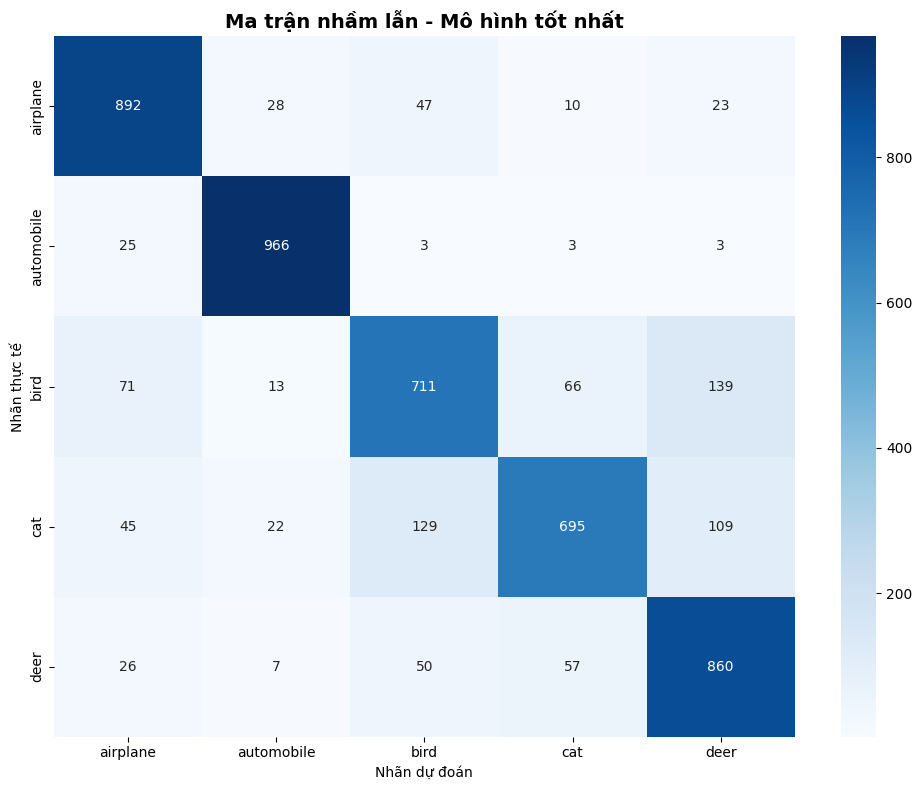

In [ ]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=SELECTED_CLASS_NAMES,
           yticklabels=SELECTED_CLASS_NAMES)
plt.title('Ma trận nhầm lẫn - Mô hình tốt nhất', fontsize=14, fontweight='bold')
plt.ylabel('Nhãn thực tế')
plt.xlabel('Nhãn dự đoán')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

wandb.log({"confusion_matrix": wandb.Image('confusion_matrix.png')})

In [ ]:
# Classification report
from sklearn.metrics import classification_report

print("\nBáo cáo phân loại:")
print(classification_report(true_labels, predictions,
                          target_names=SELECTED_CLASS_NAMES))


Báo cáo phân loại:
              precision    recall  f1-score   support

    airplane       0.84      0.89      0.87      1000
  automobile       0.93      0.97      0.95      1000
        bird       0.76      0.71      0.73      1000
         cat       0.84      0.69      0.76      1000
        deer       0.76      0.86      0.81      1000

    accuracy                           0.82      5000
   macro avg       0.83      0.82      0.82      5000
weighted avg       0.83      0.82      0.82      5000



## 15. Lưu mô hình tốt nhất

In [ ]:
# Lưu model
torch.save({
    'model_state_dict': best_model_state,
    'class_mapping': class_mapping,
    'selected_classes': SELECTED_CLASSES,
    'class_names': SELECTED_CLASS_NAMES,
    'test_accuracy': test_acc,
}, 'best_cifar10_model.pth')

print("Đã lưu mô hình tốt nhất: best_cifar10_model.pth")

# Upload to WandB
wandb.save('best_cifar10_model.pth')
print("Đã upload model lên WandB")

Đã lưu mô hình tốt nhất: best_cifar10_model.pth
Đã upload model lên WandB


## 16. Tạo giao diện Gradio

In [ ]:
def predict_image(image):
    """
    Dự đoán lớp cho ảnh đầu vào
    """
    # Chuyển đổi ảnh
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image.astype('uint8'), 'RGB')

    # Resize nếu cần
    image = image.resize((32, 32))

    # Transform
    image_tensor = transform_basic(image).unsqueeze(0).to(DEVICE)

    # Predict
    best_model.eval()
    with torch.no_grad():
        outputs = best_model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    # Kết quả
    predicted_class = SELECTED_CLASS_NAMES[predicted.item()]
    confidence_score = confidence.item() * 100

    # Tạo dictionary cho tất cả các lớp
    all_probs = {SELECTED_CLASS_NAMES[i]: float(probabilities[0][i])
                for i in range(len(SELECTED_CLASS_NAMES))}

    return all_probs

# Tạo giao diện
demo = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy", label="Upload hoặc chụp ảnh"),
    outputs=gr.Label(num_top_classes=5, label="Dự đoán"),
    title="Phân loại ảnh CIFAR-10 (5 lớp)",
    description=f"Mô hình phân loại ảnh thành 5 lớp: {', '.join(SELECTED_CLASS_NAMES)}.\n\n"
                f"Độ chính xác Test: {test_acc:.2f}%\n\n"
                f"Upload hoặc chụp ảnh để dự đoán!",
    examples=[
        [np.array(trainset_full[train_indices[i]][0]) for i in [0, 1000, 2000, 3000, 4000]]
    ],
    theme=gr.themes.Soft()
)

# Launch
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://8ed9b769b76138c899.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8ed9b769b76138c899.gradio.live


## 17. Kết luận và Nhận xét

In [ ]:
print("="*80)
print("KẾT LUẬN VÀ NHẬN XÉT")
print("="*80)

print("\n1. ẢNH HƯỞNG CỦA DATA AUGMENTATION:")
print("-" * 80)
print(f"   Cải thiện độ chính xác trung bình: {improvement:+.2f}%")
print(f"   Trung bình không Aug: {avg_best_acc_no_aug:.2f}%")
print(f"   Trung bình có Aug: {avg_best_acc_with_aug:.2f}%")

if improvement > 0:
    print("\n   Data Augmentation đã cải thiện hiệu năng mô hình:")
    print("   - Tăng cường đã tạo thêm dữ liệu train đa dạng")
    print("   - Giảm overfitting, tăng khả năng tổng quát hóa")
    print("   - Mô hình học được các biến thể khác nhau của ảnh")
else:
    print("\n   Data Augmentation không cải thiện rõ rệt:")
    print("   - Có thể do augmentation quá mạnh")
    print("   - Cần điều chỉnh các tham số augmentation")

print("\n2. TỐC ĐỘ HỘI TỤ:")
print("-" * 80)
print(f"   Chênh lệch thời gian huấn luyện: {time_diff:+.2f}s")
print(f"   Không Aug: {avg_time_no_aug:.2f}s")
print(f"   Có Aug: {avg_time_with_aug:.2f}s")
print("\n   Augmentation làm tăng thời gian train do:")
print("   - Các phép biến đổi được áp dụng realtime")
print("   - Mỗi epoch xử lý nhiều dữ liệu hơn")

print("\n3. ĐỘ ỔN ĐỊNH QUA CÁC LẦN CHẠY:")
print("-" * 80)
std_no_aug = np.std([r['best_acc'] for r in results_no_aug])
std_with_aug = np.std([r['best_acc'] for r in results_with_aug])
print(f"   Độ lệch chuẩn (Không Aug): {std_no_aug:.2f}%")
print(f"   Độ lệch chuẩn (Có Aug): {std_with_aug:.2f}%")

print("\n4. KHUYẾN NGHỊ:")
print("-" * 80)
print("   - Data Augmentation là kỹ thuật quan trọng cho Computer Vision")
print("   - Nên chạy nhiều lần để đánh giá độ ổn định")
print("   - Điều chỉnh các tham số augmentation dựa trên dataset")
print("   - Sử dụng WandB để theo dõi và so sánh experiments")

print("\n" + "="*80)
print("HOÀN THÀNH LAB 02 - BÀI 2")
print("="*80)

# Finish WandB
wandb.finish()

KẾT LUẬN VÀ NHẬN XÉT

1. ẢNH HƯỞNG CỦA DATA AUGMENTATION:
--------------------------------------------------------------------------------
   Cải thiện độ chính xác trung bình: -0.27%
   Trung bình không Aug: 82.23%
   Trung bình có Aug: 81.97%

   Data Augmentation không cải thiện rõ rệt:
   - Có thể do augmentation quá mạnh
   - Cần điều chỉnh các tham số augmentation

2. TỐC ĐỘ HỘI TỤ:
--------------------------------------------------------------------------------
   Chênh lệch thời gian huấn luyện: +178.99s
   Không Aug: 148.99s
   Có Aug: 327.98s

   Augmentation làm tăng thời gian train do:
   - Các phép biến đổi được áp dụng realtime
   - Mỗi epoch xử lý nhiều dữ liệu hơn

3. ĐỘ ỔN ĐỊNH QUA CÁC LẦN CHẠY:
--------------------------------------------------------------------------------
   Độ lệch chuẩn (Không Aug): 0.17%
   Độ lệch chuẩn (Có Aug): 0.37%

4. KHUYẾN NGHỊ:
--------------------------------------------------------------------------------
   - Data Augmentation là kỹ t